<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/main/template-report-Navier-Stokes-ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations - ALE**
**Emil Gestsson, using template by Johan Hoffman**

# **Abstract**

This contains a solution to question 1 of Lab 4. Qeustion 2 is answered in a different file, which is suffexed _elasticity instead of _ALE.

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The question consists of 2 parts:

1.   Inital observations where lift and drag forces are plotted, analysed and compared.
2.   Changing the deformation code s.t. the cylinder is not displaced, followed by another analysis and comparison.

The way I changed the deformation code to not move the cylinder was to make deformation symmetrical around the cylinder center, which was implemented by multiplying the deformation with the signed distance to the cylinder center.


The template was also modified to compute drag and lift simultaneously.

---



# **Method**

**Define domain and mesh**

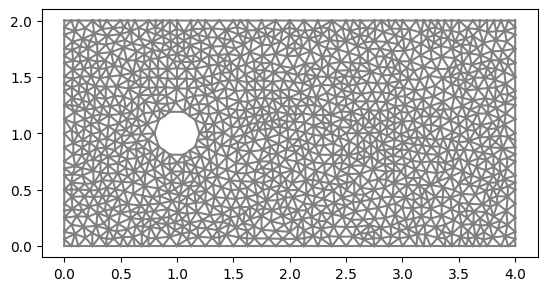

In [89]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [90]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [91]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

**Define flow parameters**

In [92]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

In [93]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Define mesh deformation w, mesh velocity = w/dt
amp_x = 0.0
amp_y = 1.0e-2
freq = 0.1
t = 0.0
#w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())
w = Expression((f"amp_x*(x[0] - {yc})*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)", f"amp_y*(x[1] - {yc})*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [94]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [95]:
# Define the direction of the force to be computed
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force_Lift = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx


phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)
Force_Drag = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx


#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [96]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Force computation data
force_lift_array = np.array(0.0)
force_lift_array = np.delete(force_lift_array, 0)

force_drag_array = np.array(0.0)
force_drag_array = np.delete(force_drag_array, 0)

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    w.t = t
    ALE.move(mesh, w)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        FL = assemble(Force_Lift)
        FD = assemble(Force_Drag)
        if (t > start_sample_time):
          force_lift_array = np.append(force_lift_array, normalization*FL)
          force_drag_array = np.append(force_drag_array, normalization*FD)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        plot(mesh, title="Mesh")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.plot(time, force_drag_array)
        plt.plot(time, force_lift_array)
        plt.title("Force");
        plt.legend(["drag", "lift"])
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# Results



## Displaced and Deformed cylinder

Here is a plot of the drag and lift force across time:

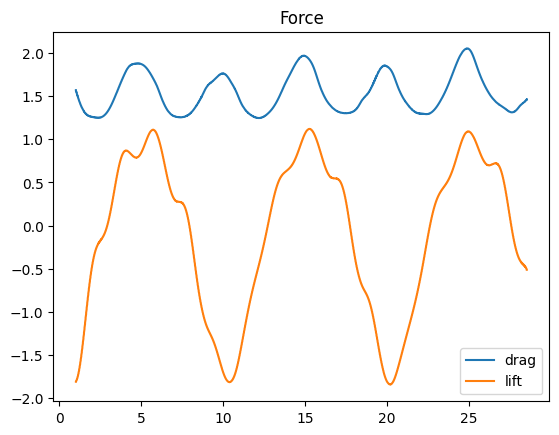

And here are three plots of the meshes at times t=7.52:

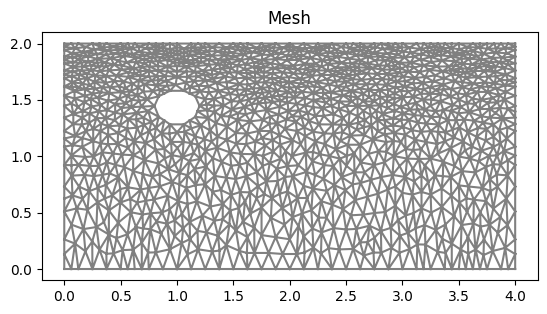

t = 0:

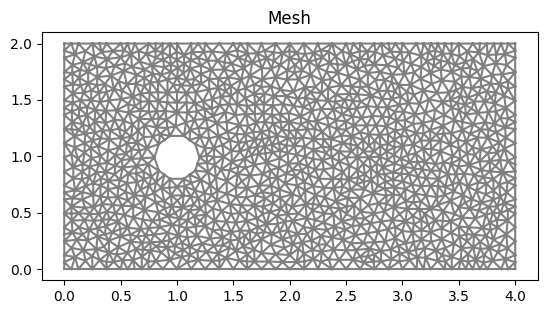

and t = 22.5:

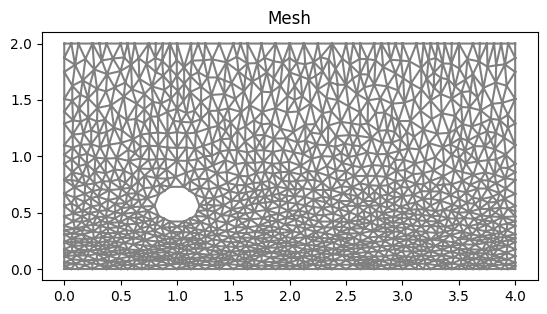

which portray the three main ways the mesh is deformed.

The drag force is consistently reduced as the cylinder becomes narrower, which is expected since the shape becomes more streamlined.

A surprise for me was that the downward lift force peaked at a very similar value when compared with the force at t=0, even though they are considerably different in terms of displacement and shape. Notably, since the top half is rounder one would naturally assume that it would be pushed downwards more. But the fact that the values ended up being so close is likely a coincidence.


## Unmoving but Defored cylinder

By multiplying deformation by the signed distance to the cylinder, it was made symmetric and resulted in the following forces:



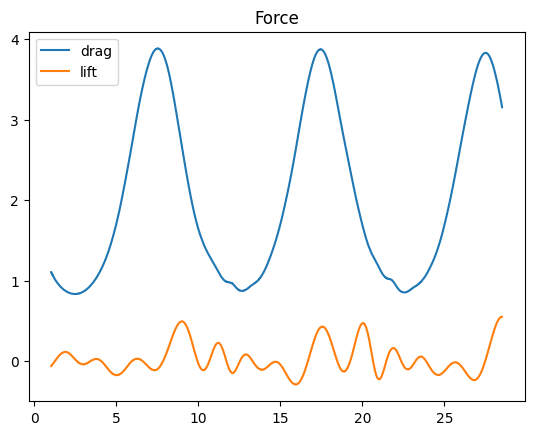

and the mesh distortion roughly ranged between these two extremes:
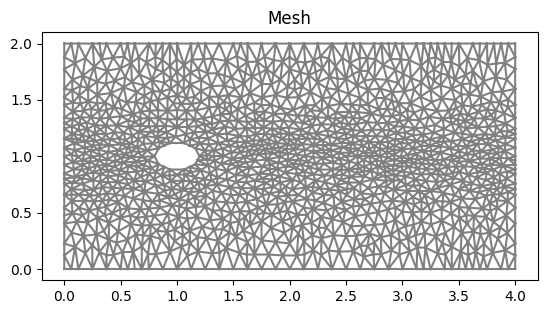

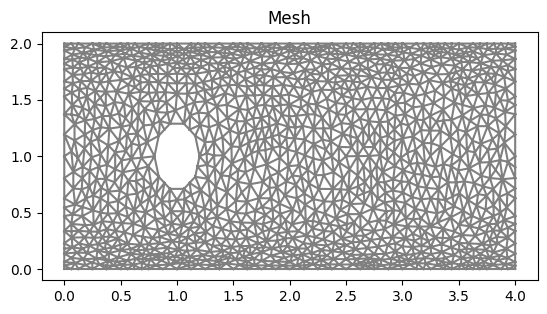

which the drag force naturally reflected. Lift force was a lot more chaotic but we could see consistent spikes as the cylinder began narrowing down from its most stretched position, the remaining sections appear like random waves with a somewhat similar interval.

# **Discussion**